In [92]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader,Subset
import numpy as np
import matplotlib.pyplot as plt
import numba
import sys
np.set_printoptions(threshold=sys.maxsize,linewidth=1000,suppress=True)

#### __The following code block simulates heat diffusion in 1 dimension__

This could be a rod for example. This is done using the finite difference method to solve the partial differential equation.

In [93]:
dt = 0.001
dx = 0.1
L = 10
t_end = 50
th = 100
time = np.arange(0,t_end,dt)
heat_map = np.zeros(int(L/dx)+1)
heat_map[0] = th


@numba.jit(nopython=True,nogil=True)
def heat_diffusion(a,initial_temp):
    snapshots = np.zeros((time.shape[0],int(L/dx)+1))
    snapshots[0] = initial_temp
    current_heat_map = initial_temp
    for t in range(time.shape[0]-1):
        for x in range(1,heat_map.shape[0]-1):
            current_heat_map[x] = ((a*dt)/dx**2)*(current_heat_map[x+1]-2*current_heat_map[x]+current_heat_map[x-1]) + current_heat_map[x]
        snapshots[t+1] = current_heat_map
    return snapshots
snaps = heat_diffusion(0.5,heat_map)


Next, we define a function create_x_values() in order to put the parameters of T (temperature) into the correct format.
That format is the following
<br><br>
$[[x_1,t_1],[x_1,t_2],[x_1,t_3]...[x_1,t_n]...[x_2,t_n]...]$
<br><br>
That is, the temperature is determined by where the point is in space and time

In [94]:
#define function to create x values in correct format and create dataset class
def create_x_values():
    x_values = np.arange(dx,L,dx)
    repeat_array = np.repeat(x_values,time.shape[0])
    time_repeat = np.concatenate([time]*x_values.shape[0],axis=0)

    x = np.zeros((time.shape[0]*x_values.shape[0],2))
    x[:,0] = repeat_array
    x[:,1] = time_repeat
    return x
class HeatDataset(Dataset):
    def __init__(self, data):
        data = data[:,1:-1].transpose().reshape(1,data[:,1:-1].size).ravel()
        self.x,self.y = torch.tensor(create_x_values(),dtype=torch.float),torch.tensor(data,dtype=torch.float)
        self.x[:,0],self.x[:,1] = self.x[:,0]/L,self.x[:,1]/t_end

    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx]

Then, we create a dataset class, from which we split into training and test data.

In [95]:
dataset = HeatDataset(snaps)
N = len(dataset)


indices = np.random.permutation(np.arange(N))

train_idx = indices[:int(0.7*N)]
test_idx = indices[int(0.7*N):]

train_data = Subset(dataset,train_idx)
test_data = Subset(dataset,test_idx)

train_dl = DataLoader(train_data, batch_size=64,shuffle=True)

Now, we create a custom nueral network in order to tune parameters for the ML model to replicate heat diffusion as closely as possible.

In [96]:
#basic outline of a machine learning model, custom neural net class with forward function and a train model function which operates on 'f'
# and changes it weights and then calling f(x) is the same as f.forward(x)
class NueralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,80)
        self.Matrix3 = nn.Linear(80,1)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()


def train_model(train_dl,f, n_epochs):
    optimizer = SGD(f.parameters(), lr=0.001)
    Loss = nn.MSELoss()

    losses_list = []
    for epoch in range(n_epochs):
        for x,y in train_dl:
            optimizer.zero_grad()
            loss_value = Loss(f(x), y)
            loss_value.backward()
            optimizer.step()
            losses_list.append(loss_value.item())
    return losses_list

The neural network class is called and the model is trained a certain number of epochs.

In [97]:
f = NueralNetwork()
n_epochs = 1
losses = train_model(train_dl,f,n_epochs)

Afterwards, the losses vs epoch graph is plotted to analyze how well the model did.

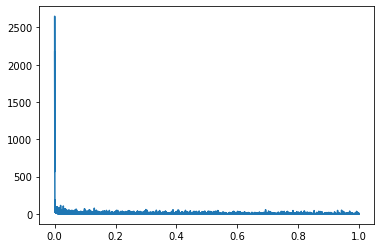

In [98]:
plt.plot(np.linspace(0,n_epochs,len(losses)),losses)
plt.show()

The model is then tested on the test data, and the mean difference between the simulated data and the predicted data is shown for analyzing performance.

In [99]:

x,y = test_data[:]

np.mean(np.abs((y-f(x)).detach().numpy()))


0.42571217


Lastly, the simulated vs. predicted temperature profile is shown at certain time points to visualize the effectiveness of the ML model. Blue is the model and orange is the simulated data.

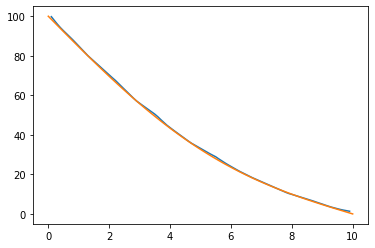

In [110]:
t_plot = 25
t = t_plot/t_end
snapshot = []

for x in np.arange(dx,L,dx):
    snapshot.append(f(torch.tensor([x/L,t],dtype=torch.float)).detach().numpy())

plt.plot(np.arange(dx,L,dx),snapshot)
plt.plot(np.arange(0,L+dx,dx),snaps[int(t_plot/dt)])
plt.show()